# build a basic chatbot with langraph(graph API)

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END 
from langgraph.graph.message import add_messages # reducers


In [5]:
class State(TypedDict): # return type is dictionary
    # messages have the type "list". the add_messages function
    # in the annotation defines how this state key should be updated 
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list,add_messages]
graph_builder=StateGraph(State)

In [6]:
graph_builder

In [7]:
import os 
from dotenv import load_dotenv
load_dotenv()

True

In [8]:
# define LLM's
from langchain_groq import ChatGroq
from langchain_openai import AzureChatOpenAI

llm_open_ai=AzureChatOpenAI(
    azure_deployment='gpt-4o',
    api_key=os.getenv('AZURE_OPENAI_GPT_4O_API_KEY'),
    azure_endpoint=os.getenv('AZURE_OPENAI_GPT_4O_API_ENDPOINT'),
    api_version=os.getenv('AZURE_OPENAI_GPT_4O_API_VERSION')
)

llm_groq=ChatGroq(model='deepseek-r1-distill-llama-70b',api_key=os.getenv('GROQ_API'))


# create a chatbot node

In [9]:
def chatbot(state:State):
    return {'messages':[llm_open_ai.invoke(state['messages'])]}


In [10]:
graph_builder=StateGraph(State)
## Adding node
graph_builder.add_node('llmchatbot',chatbot)
graph_builder.add_edge(START,'llmchatbot')
graph_builder.add_edge('llmchatbot',END)

## compile the graph 
graph=graph_builder.compile()


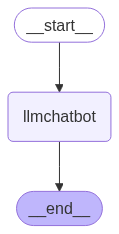

In [11]:
## Visualize the graph 
from IPython.display import Image,display 

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass 

In [22]:
response=graph.invoke({'messages':'what is life?'})

In [13]:
response['messages'][-1].content

'Hello! How can I assist you today? 😊'

In [14]:
for event in graph.stream({'messages':'Hi How are you?'}):
    for val in event.values():
        print(val['messages'][-1].content)

Hello! I'm just a virtual assistant, so I don't have feelings, but I'm ready and excited to help you with anything you need. 😊 How are *you* doing?


In [24]:
from langchain_core.messages import HumanMessage
response = graph.invoke({"messages": [HumanMessage(content="Hi")]})
response = graph.invoke({"messages": [HumanMessage(content="sup")]})
for msg in response['messages']:
    print(f"{msg.type.upper()}: {msg.content}")


HUMAN: sup
AI: Hey there! What's up? How can I help you today? 😊


# chatbot with tools 

In [ ]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke('what is langgraph')

{'query': 'what is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'What Is LangGraph and How to Use It? - DataCamp',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interactions.',
   '

In [63]:
## Custom function 
def multiply(a:int,b:int)-> int:
    """ 
    Multiply a and b
    Agrs:
        a (int): first int
        b (int): second int 
    Returns:
        int: output int     
    """
    return a*b


In [64]:
tools=[tool,multiply]

In [65]:
llm_with_tools=llm_open_ai.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=AzureChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000002605E4440B0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000002605E8FEC30>, root_client=<openai.lib.azure.AzureOpenAI object at 0x000002605DFEF9E0>, root_async_client=<openai.lib.azure.AsyncAzureOpenAI object at 0x000002605E0D76B0>, model_kwargs={}, openai_api_key=SecretStr('**********'), disabled_params={'parallel_tool_calls': None}, azure_endpoint='https://llmops-amruth.openai.azure.com/', deployment_name='gpt-4o', openai_api_version='2024-12-01-preview', openai_api_type='azure'), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range fil

In [66]:
## state graph 
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# node definition 
def tool_calling_llm(state:State):
    return {'messages':[llm_with_tools.invoke(state['messages'])]}

## create a graph 
builder=StateGraph(State)
builder.add_node('tool_calling_llm',tool_calling_llm)
builder.add_node('tools',ToolNode(tools))
builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges(
    'tool_calling_llm',tools_condition
    # if the latest message (result) from assistant is a tool call -> tools_confition routes to tools 
    # if the latest message (result) from assistant is not a tool call -> tools_confition routes to END 
)
builder.add_edge('tools',END)
graph=builder.compile()

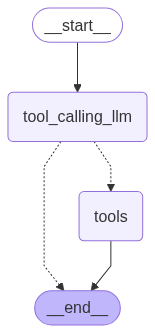

In [67]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [68]:
response=graph.invoke({"messages":'what is the resent AI news?'})
response

{'messages': [HumanMessage(content='what is the resent AI news?', additional_kwargs={}, response_metadata={}, id='b9a3a8e3-11be-419b-98a7-9e1f3c98040c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_PDcmUbq89TY8wJPmSwE50GTD', 'function': {'arguments': '{"query":"recent AI news","search_depth":"advanced","time_range":"week","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 823, 'total_tokens': 856, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BlRWKzEkbDiHVxfGMWm3GWsDp1sK4', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity':

In [69]:
response['messages'][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.techtarget.com/searchenterpriseai/news/366626101/Apple-AI-paper-likely-self-serving-but-has-some-merit", "title": "Apple AI paper likely self-serving but has some merit - TechTarget", "score": 0.61307496, "published_date": "Tue, 17 Jun 2025 20:18:27 GMT", "content": "\\"The ambition and the hope are warranted, but if these systems can\'t perform even on moderately complex tasks, then it\'s better to understand it relatively early on,\\" Bennett added.\\n\\nMeanwhile, on June 16, Chinese vendor Alibaba revealed that its new Qwen 3 models will run on Apple devices, including iPhone, iPad, MacBook and Mac.\\n\\n_Esther Shittu is an Informa TechTarget news writer and podcast host covering AI software and systems._\\n\\n#### Related Resources [...] Investment in AI continues to grow. Meta, Amazon, Alphabet (Google\'s parent company) and Microsoft are expected to invest bi

In [70]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the resent AI news?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_PDcmUbq89TY8wJPmSwE50GTD)
 Call ID: call_PDcmUbq89TY8wJPmSwE50GTD
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: week
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.techtarget.com/searchenterpriseai/news/366626101/Apple-AI-paper-likely-self-serving-but-has-some-merit", "title": "Apple AI paper likely self-serving but has some merit - TechTarget", "score": 0.61307496, "published_date": "Tue, 17 Jun 2025 20:18:27 GMT", "content": "\"The ambition and the hope are warranted, but if these systems can't perform even on moderately complex tasks, then it's

In [71]:
response=graph.invoke({"messages":'2*3?'})
response

{'messages': [HumanMessage(content='2*3?', additional_kwargs={}, response_metadata={}, id='8b340d2c-9063-444d-a3ab-a3e3e6d12914'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_I0Mb4uOib8ZIVkNIQR3GwbtL', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 820, 'total_tokens': 838, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BlRWNLcAAlmtwqB83xcsHFt2QRTU7', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'sever

In [72]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

2*3?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_I0Mb4uOib8ZIVkNIQR3GwbtL)
 Call ID: call_I0Mb4uOib8ZIVkNIQR3GwbtL
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [73]:
response=graph.invoke({"messages":'2*3*10?'})
response

{'messages': [HumanMessage(content='2*3*10?', additional_kwargs={}, response_metadata={}, id='b4f7e352-46d9-4ba4-b9d3-24db3d03c780'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0P8mfBtcORxZtn8ddvrN5a9b', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_9ohDNlqkVjDI9wD9ix6oyQMy', 'function': {'arguments': '{"a": 6, "b": 10}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 822, 'total_tokens': 873, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BlRYUTzJCtCh8eVR7zbzMVSOZUG7d', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate'

In [74]:
response=graph.invoke({"messages":'what is the latest AI news and how is NVIDIA stock?'})
response

{'messages': [HumanMessage(content='what is the latest AI news and how is NVIDIA stock?', additional_kwargs={}, response_metadata={}, id='a5f75f36-7551-4a43-8fe2-2c919f2c0333'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MTzJIpJes9eV296K2iN2JZvW', 'function': {'arguments': '{"query": "latest AI news", "search_depth": "advanced", "time_range": "day", "topic": "news"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'call_hsrYPeN01FbSUSDNaLxiVZhV', 'function': {'arguments': '{"query": "NVIDIA stock performance", "topic": "finance", "time_range": "day"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 828, 'total_tokens': 905, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-2

## react agent architecture 

In [76]:
## state graph 
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# node definition 
def tool_calling_llm(state:State):
    return {'messages':[llm_with_tools.invoke(state['messages'])]}

## create a graph 
builder=StateGraph(State)
builder.add_node('tool_calling_llm',tool_calling_llm)
builder.add_node('tools',ToolNode(tools))
builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges(
    'tool_calling_llm',tools_condition
    # if the latest message (result) from assistant is a tool call -> tools_confition routes to tools 
    # if the latest message (result) from assistant is not a tool call -> tools_confition routes to END 
)
builder.add_edge('tools','tool_calling_llm')
graph=builder.compile()

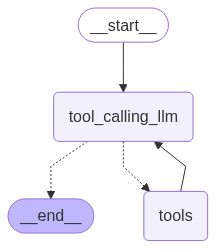

In [77]:
from IPython.display import Image,display 

from IPython.display import Image, display 
display(Image(graph.get_graph().draw_mermaid_png()))

In [89]:
response=graph.invoke({'messages':'give me the resent AI news and what is 3*10*12'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

give me the resent AI news and what is 3*10*12
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_sT62MEjr3C15kjgLa9FZz8Mi)
 Call ID: call_sT62MEjr3C15kjgLa9FZz8Mi
  Args:
    query: recent AI news
    time_range: week
    topic: news
  multiply (call_3R9Rb8WvwnMF4KjeuIRs3uAx)
 Call ID: call_3R9Rb8WvwnMF4KjeuIRs3uAx
  Args:
    a: 3
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.investopedia.com/meta-and-oakley-are-launching-ai-powered-glasses-this-summer-11758359", "title": "Meta and Oakley Are Launching AI-Powered Glasses This Summer - Investopedia", "score": 0.6914979, "published_date": "Fri, 20 Jun 2025 17:52:50 GMT", "content": "Image 3: Meta CEO Mark Zuck

In [92]:
response=graph.invoke({'messages':'Hello whats my name?'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello whats my name?
================================== Ai Message ==================================

You haven't shared your name with me yet! What's your name?


# Adding memory in Agentic Graph

In [ ]:
# state class 
from langgraph.prebuilt import ToolNode 

class State(TypedDict):
    messages:Annotated[list,add_messages]
builder=StateGraph(State)

# add chatbot node
def chatbot(state:State):
    return {'messages':[llm_open_ai.invoke(state['messages'])]}

tool=TavilySearch(max_results=2)
tools=[tool,multiply]

llm_with_tools=llm_open_ai.bind_tools(tools)



In [101]:
# stategraph 
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {'messages':[llm_with_tools.invoke(state['messages'])]}

## create a graph 
builder1=StateGraph(State)
builder1.add_node('tool_calling_llm',tool_calling_llm)
builder1.add_node('tools',ToolNode(tools))
builder1.add_edge(START,'tool_calling_llm')
builder1.add_conditional_edges('tool_calling_llm',tools_condition)
builder1.add_edge('tools','tool_calling_llm')

# add memory and compile 
graph=builder1.compile(checkpointer=memory)


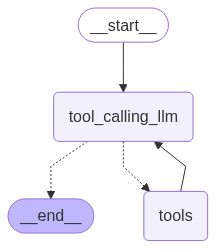

In [102]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [104]:
# creating thread variable 
config={'configurable':{'thread_id':'1'}}
response=graph.invoke({'messages':'Hi my name is amruth'},config=config)

response

{'messages': [HumanMessage(content='Hi my name is amruth', additional_kwargs={}, response_metadata={}, id='9491fe69-4816-4991-85c9-ab8b6c868004'),
  AIMessage(content="Hello Amruth! It's great to meet you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 823, 'total_tokens': 843, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-Blbzt8wfcspfHjVB573SEQY2hB1b7', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'sa

In [106]:
response=graph.invoke({'messages':'what is 3 multiplied by 10 also what is the latest news on USA and IRAN?'},config=config)
response

{'messages': [HumanMessage(content='Hi my name is amruth', additional_kwargs={}, response_metadata={}, id='9491fe69-4816-4991-85c9-ab8b6c868004'),
  AIMessage(content="Hello Amruth! It's great to meet you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 823, 'total_tokens': 843, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-Blbzt8wfcspfHjVB573SEQY2hB1b7', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'sa

In [107]:
response=graph.invoke({'messages':'what is my name?'},config=config)
response

{'messages': [HumanMessage(content='Hi my name is amruth', additional_kwargs={}, response_metadata={}, id='9491fe69-4816-4991-85c9-ab8b6c868004'),
  AIMessage(content="Hello Amruth! It's great to meet you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 823, 'total_tokens': 843, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-Blbzt8wfcspfHjVB573SEQY2hB1b7', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'sa